In [1]:
import torch
from unet import UNet

model_path = "./model.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Loading model {model_path}')
print(f'Using device {device}')

model = UNet(in_channels=3, out_channels=1).to(device)
state_dict = torch.load(model_path, map_location=device)
# print(state_dict.keys())
# print(model.state_dict().keys())
model.load_state_dict(state_dict)

print('Model loaded')

Loading model ./model.pth
Using device cuda
Model loaded


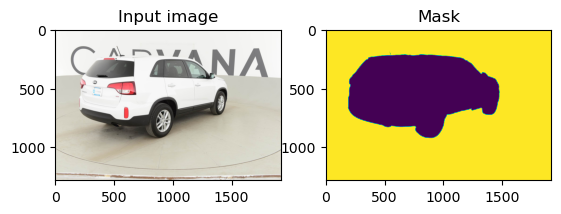

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

img_path = '../../Images/infer.jpg'
threadhold = 0.9

def plot_img_and_mask(img, mask):
    classes = mask.max()
    fig, ax = plt.subplots(1, classes + 1)
    ax[0].set_title('Input image')
    ax[0].imshow(img)
    ax[1].set_title('Mask')
    ax[1].imshow(mask == 0)
    fig.show()

# Open image
img = Image.open(img_path)
transform = transforms.Compose([
    transforms.Resize((572, 572)),
    transforms.ToTensor(),
])
img_tensor = transform(img).unsqueeze(0).to(device, dtype=torch.float32)

# Inference
with torch.no_grad():
    mask = model(img_tensor)

# Postprocessing
mask = mask.cpu()
mask = F.interpolate(
    mask,
    size=img.size[::-1],
    mode='bilinear',
    align_corners=False
)
# Thresholding
mask = (torch.sigmoid(mask) > threadhold)
# Change to HWC format
mask = mask.squeeze(0).permute(1, 2, 0).numpy().astype(np.uint8)

# Plot
plot_img_and_mask(img, mask)